In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pickle
import qutip as qtp

from bi_PE_polytope import PE_analysis
from bi_lib import *

In [2]:
alpha = 8

In [3]:
def getDistAsymCHSH(alpha, w):
    # Tilted correlation
    E_tilted = np.zeros((3,3))
    E_tilted[0,0] = 1
    E_tilted[1,1] = alpha/np.sqrt(1+alpha**2)
    E_tilted[1,2] = alpha/np.sqrt(1+alpha**2)
    E_tilted[2,1] = 1/np.sqrt(1+alpha**2)
    E_tilted[2,2] = -1/np.sqrt(1+alpha**2)
    P_tilted = E2p_bi(E_tilted)
    
    # White noise
    P_wn = np.zeros((2,2,2,2))
    for a,b,x,y in it.product(range(2),repeat=4):
        P_wn[a,b,x,y] = 1/4
    
    return (1-w)*P_tilted + w*P_wn

CHSH_ineq = CHSH_ineqs[0].copy()
####################################
asymCHSH_ineq = np.zeros((2,2,2,2))
asymCHSH_ineq[0,0,0,0] = alpha
asymCHSH_ineq[1,1,0,0] = alpha
asymCHSH_ineq[0,1,0,0] = -alpha
asymCHSH_ineq[1,0,0,0] = -alpha
asymCHSH_ineq[0,0,0,1] = alpha
asymCHSH_ineq[1,1,0,1] = alpha
asymCHSH_ineq[0,1,0,1] = -alpha
asymCHSH_ineq[1,0,0,1] = -alpha
asymCHSH_ineq[0,0,1,0] = 1
asymCHSH_ineq[1,1,1,0] = 1
asymCHSH_ineq[0,1,1,0] = -1
asymCHSH_ineq[1,0,1,0] = -1
asymCHSH_ineq[0,0,1,1] = -1
asymCHSH_ineq[1,1,1,1] = -1
asymCHSH_ineq[0,1,1,1] = 1
asymCHSH_ineq[1,0,1,1] = 1
####################################

# Asymmetric CHSH

This is an example code for randomness certification with asymmetric CHSH correlations with independent input source; see Section 4.1.1 in our paper. 

The primary object in our library is a class called 'PE_analysis', which can be defined with (i) some typical correlation of the devices, (ii) input distribution, (iii) input distribution polytope ('None' if the input distribution is independent and fixed), (iv) the choice of the NPA hierarchy level to be used. 'PE_analysis' then takes care of generating polytope-approximations for a given typical correlation, finding optimal PEFs, and calculating the extractable entropy for some given data.

The general process of using our codes is:
1. Define 'PE_analysis' for given typical correlation of the devices and the input distribution.
2. Generate polytope-approximations for the quantum set - where one can use our 'NearV' and 'MaxGP' algorithms to construct polytopes taylored for the typical correlation. If there is any known polytope-approximation, one can also add it to the class using 'add_Poly_option' function (see the example below).
3. Find optimal PEFs using the typical correlation for many different (fixed) powers - this step corresponds to the simpler optimisation in Eq.(18) in our paper.
4. Randomness accumulation for some given data - this step involves (i) finding the optimal PEF, optimal power, and optimal $\epsilon$ for given data, and (ii) calculating the extractable entropy (rate). The data is typically in the form of counts for each incident (a,b,x,y).

Note that the typical correlation used in step 1-3 is normally different from the data used for randomness accumulation in step 4. The typical correlation can be obtained in advance during the characterisation stage.

### 0.1% white noise

In [4]:
# Generate quantum correlation
P_in = np.array([[1/4,1/4],[1/4,1/4]]) # Input distribution
P_asymCHSH_wnd001 = getDistAsymCHSH(alpha, 0.001) # P_reg - no need for regularisation
E_asymCHSH_wnd001 = p2E_bi(P_asymCHSH_wnd001)
print("CHSH value:", -np.einsum('ij,ij->', CHSH_ineq, E_asymCHSH_wnd001)+2)
print("Asymmetric CHSH value:", np.einsum('ijkl,ijkl->',asymCHSH_ineq,P_asymCHSH_wnd001))
sec = 2**(-128)

CHSH value: 2.2303925973831467
Asymmetric CHSH value: 16.108390981100502


In [5]:
### Define the PE_analysis class for asymmetric CHSH correlation with 0.1% white noise ###
asymCHSH_wnd001 = PE_analysis(P_asymCHSH_wnd001, P_in)

In [15]:
### Generate various polytopes ###
# NS polytope
asymCHSH_wnd001.generate_Poly('NS')
# NS+CHSH polytope
asymCHSH_wnd001.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=10
asymCHSH_wnd001.generate_Poly('NearV', niter=10, cutoff=10) 
# 10 iterations of MaxGP algorithm - we want fixed (instead random) input for guessing probability
asymCHSH_wnd001.generate_Poly('MaxGP', niter=10, fix_input=(0,0))

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 0
---------------------
Iteration 1 starts
Chosen index: 7
---------------------
Iteration 2 starts
Chosen index: 0
---------------------
Iteration 3 starts
Chosen index: 0
---------------------
Iteration 4 starts
Chosen index: 8
---------------------
Iteration 5 starts
Chosen index: 2
---------------------
Iteration 6 starts
Chosen index: 6
---------------------
Iteration 7 starts
Chosen index: 3
---------------------
Iteration 8 starts
Chosen index: 5
---------------------
Iteration 9 starts
Chosen index: 3
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.3...
Optimal solution no.3 i

In [8]:
### Example code for adding an extra polytope 'NS+CHSH+asymCHSH' ###
# Generate the polytope
asymCHSH_ineq_E = np.zeros((3,3))
asymCHSH_ineq_E[0,0] = 2*np.sqrt(1+alpha**2)
asymCHSH_ineq_E[1,1] = -alpha
asymCHSH_ineq_E[1,2] = -alpha
asymCHSH_ineq_E[2,1] = -1
asymCHSH_ineq_E[2,2] = 1

ineqs = positivity_NS[:] + [asymCHSH_wnd001.q_rel_CHSH_ineq[:]] + [asymCHSH_ineq_E]

H_rep = []
for ineq in ineqs:
    H_rep.append([str(i) for i in ineq.flatten()])
    
mat = cdd.Matrix(H_rep, number_type='fraction')
mat.rep_type = cdd.RepType.INEQUALITY
poly = cdd.Polyhedron(mat)
V_rep_fraction = np.array(poly.get_generators())

asymCHSH_V_rep = []
for ext in V_rep_fraction:
    asymCHSH_V_rep.append(np.array([float(i) for i in ext]))
    
# Add the polytope
asymCHSH_wnd001.add_Poly_option('NS+CHSH+asym', [asymCHSH_V_rep])

In [16]:
### Opimise PEF for fixed PEF power ###
asymCHSH_wnd001.max_power = 0.05 # The maximum power for which we want to optimise PEF
first_power = 0.0001 # The minimum power for which we want to optimise PEF
n_points = 151 # The number of points between the maximum and minimum powers for which we want to optimise PEF
# NS polytope
asymCHSH_wnd001.get_optF('NS', first_power=first_power, n_points=n_points)
# NS+CHSH polytope
asymCHSH_wnd001.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)
# NS+CHSH+asym polytope
asymCHSH_wnd001.get_optF('NS+CHSH+asym', first_power=first_power, n_points=n_points)
# NearV algorithm - we only want to optimise PEF for the 10 iterations case -> n_list only has one element '9'.
asymCHSH_wnd001.get_optF('NearV', n_list=[9], first_power=first_power, n_points=n_points)
# MaxGP alforithm - we only want to optimise PEF for the 10 iterations case -> n_list only has one element '9'.
asymCHSH_wnd001.get_optF('MaxGP', n_list=[9], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|█████████████████████████████████████████| 151/151 [00:14<00:00, 10.49it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|█████████████████████████████████████████| 151/151 [00:17<00:00,  8.60it/s]


=================== Optimise PEF for 'NS+CHSH+asym' ===================


100%|█████████████████████████████████████████| 151/151 [00:24<00:00,  6.25it/s]


=================== Optimise PEF for 'NearV' ===================


100%|█████████████████████████████████████████| 151/151 [04:19<00:00,  1.72s/it]


=================== Optimise PEF for 'MaxGP' ===================


100%|███████████████████████████████████████| 151/151 [1:42:14<00:00, 40.62s/it]


In [5]:
### Example code for saving and loading the 'P1' class

# with open('asymCHSH_wnd001_alpha8.pkl', 'wb') as outp:
#     pickle.dump(asymCHSH_wnd001, outp, pickle.HIGHEST_PROTOCOL)

with open('asymCHSH_wnd001_alpha8.pkl', 'rb') as inp:
    asymCHSH_wnd001 = pickle.load(inp)

In [13]:
### Analyse with different N
N_list = [2**n for n in range(13,31)]

asymCHSH_wnd001_EntR_vs_N_NS = []
asymCHSH_wnd001_EntR_vs_N_NS_CHSH = []
asymCHSH_wnd001_EntR_vs_N_NS_CHSH_asym = []
asymCHSH_wnd001_EntR_vs_N_NearV = []
asymCHSH_wnd001_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_asymCHSH_wnd001[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = asymCHSH_wnd001.randomness_accumulation(N_raw, sec, 'NS', n_list=[0])
    asymCHSH_wnd001_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = asymCHSH_wnd001.randomness_accumulation(N_raw, sec, 'NS+CHSH', n_list=[0])
    asymCHSH_wnd001_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NS+CHSH+asym'
    NS_CHSH_asym = asymCHSH_wnd001.randomness_accumulation(N_raw, sec, 'NS+CHSH+asym', n_list=[0])
    asymCHSH_wnd001_EntR_vs_N_NS_CHSH_asym.append(NS_CHSH_asym[0]['entropy rate'])
    
    # 'NearV'
    NearV = asymCHSH_wnd001.randomness_accumulation(N_raw, sec, 'NearV', n_list=[9])
    asymCHSH_wnd001_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = asymCHSH_wnd001.randomness_accumulation(N_raw, sec, 'MaxGP', n_list=[9])
    asymCHSH_wnd001_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

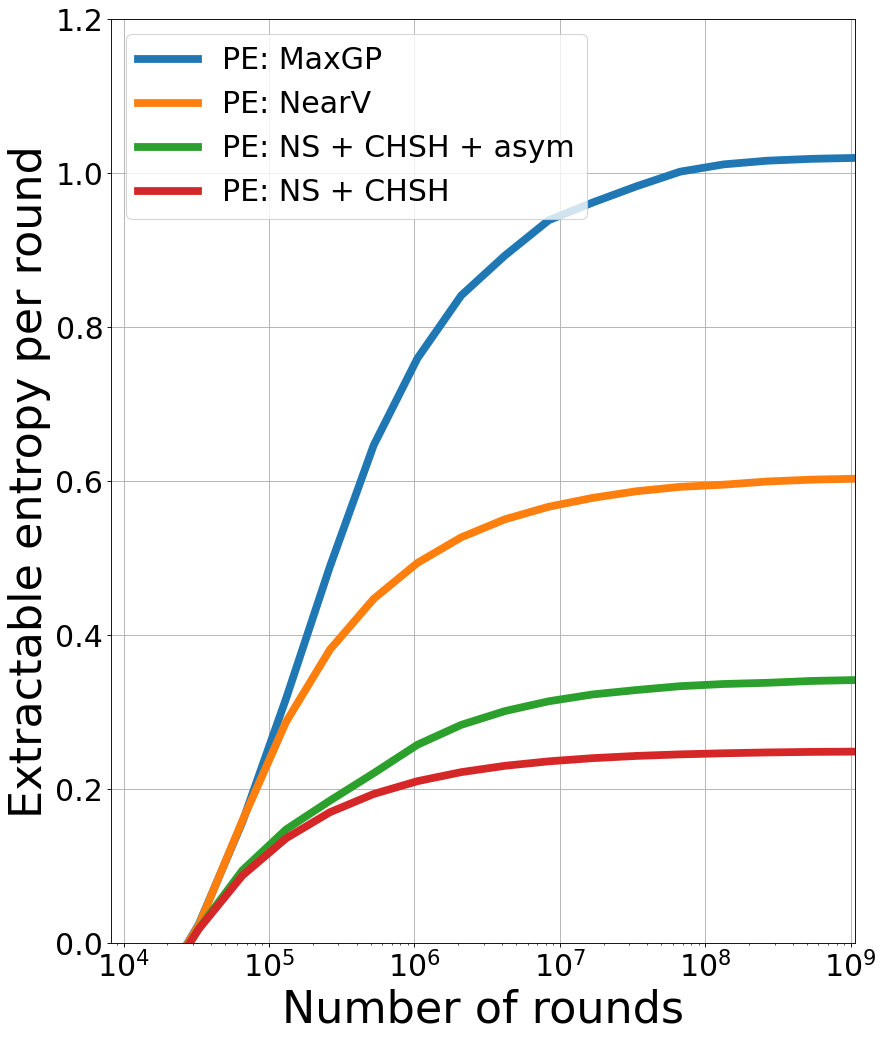

In [14]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, asymCHSH_wnd001_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, asymCHSH_wnd001_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, asymCHSH_wnd001_EntR_vs_N_NS_CHSH_asym, linewidth=7)
plt.plot(N_list, asymCHSH_wnd001_EntR_vs_N_NS_CHSH, linewidth=7)
plt.xscale('log')
plt.xlim([2**13, 2**30])
plt.ylim([0,1.2])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH + asym', 'PE: NS + CHSH'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()

### 1% white noise

In [17]:
# Generate quantum correlation
P_in = np.array([[1/4,1/4],[1/4,1/4]]) # Input distribution
P_asymCHSH_wnd01 = getDistAsymCHSH(alpha, 0.01) # P_reg - no need for regularisation
E_asymCHSH_wnd01 = p2E_bi(P_asymCHSH_wnd01)
print("CHSH value:", -np.einsum('ij,ij->', CHSH_ineq, E_asymCHSH_wnd01)+2)
print("Asymmetric CHSH value:", np.einsum('ijkl,ijkl->',asymCHSH_ineq,P_asymCHSH_wnd01))
sec = 2**(-128)

CHSH value: 2.2102989703796947
Asymmetric CHSH value: 15.963270341631128


In [18]:
### Define the PE_analysis class for asymmetric CHSH correlation with 1% white noise ###
asymCHSH_wnd01 = PE_analysis(P_asymCHSH_wnd01, P_in)

In [19]:
### Extra polytope 'NS+CHSH+asymCHSH'
# Generate the polytope
asymCHSH_ineq_E = np.zeros((3,3))
asymCHSH_ineq_E[0,0] = 2*np.sqrt(1+alpha**2)
asymCHSH_ineq_E[1,1] = -alpha
asymCHSH_ineq_E[1,2] = -alpha
asymCHSH_ineq_E[2,1] = -1
asymCHSH_ineq_E[2,2] = 1

ineqs = positivity_NS[:] + [asymCHSH_wnd01.q_rel_CHSH_ineq[:]] + [asymCHSH_ineq_E]

H_rep = []
for ineq in ineqs:
    H_rep.append([str(i) for i in ineq.flatten()])
    
mat = cdd.Matrix(H_rep, number_type='fraction')
mat.rep_type = cdd.RepType.INEQUALITY
poly = cdd.Polyhedron(mat)
V_rep_fraction = np.array(poly.get_generators())

asymCHSH_V_rep = []
for ext in V_rep_fraction:
    asymCHSH_V_rep.append(np.array([float(i) for i in ext]))
    
# Add the polytope
asymCHSH_wnd01.add_Poly_option('NS+CHSH+asym', [asymCHSH_V_rep])

In [20]:
### Generate various polytopes ###
# NS polytope
asymCHSH_wnd01.generate_Poly('NS')
# NS+CHSH polytope
asymCHSH_wnd01.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=10
asymCHSH_wnd01.generate_Poly('NearV', niter=10, cutoff=10) 
# 10 iterations of MaxGP algorithm
asymCHSH_wnd01.generate_Poly('MaxGP', niter=10, fix_input=(0,0))

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 3
---------------------
Iteration 1 starts
Chosen index: 9
---------------------
Iteration 2 starts
Chosen index: 1
---------------------
Iteration 3 starts
Chosen index: 2
---------------------
Iteration 4 starts
Chosen index: 0
---------------------
Iteration 5 starts
Chosen index: 8
---------------------
Iteration 6 starts
Chosen index: 8
---------------------
Iteration 7 starts
Chosen index: 3
---------------------
Iteration 8 starts
Chosen index: 0
---------------------
Iteration 9 starts
Chosen index: 5
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.3...
Optimal solution no.3 i

In [21]:
### Opimise PEF for fixed PEF power ###
asymCHSH_wnd01.max_power = 0.05
first_power = 0.0001
n_points = 151
# NS polytope
asymCHSH_wnd01.get_optF('NS', first_power=first_power, n_points=n_points)
# NS+CHSH polytope
asymCHSH_wnd01.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)
# NS+CHSH+asym polytope
asymCHSH_wnd01.get_optF('NS+CHSH+asym', first_power=first_power, n_points=n_points)
# NearV algorithm
asymCHSH_wnd01.get_optF('NearV', n_list=[9], first_power=first_power, n_points=n_points)
# MaxGP alforithm
asymCHSH_wnd01.get_optF('MaxGP', n_list=[9], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|█████████████████████████████████████████| 151/151 [00:13<00:00, 10.93it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|█████████████████████████████████████████| 151/151 [00:16<00:00,  9.17it/s]


=================== Optimise PEF for 'NS+CHSH+asym' ===================


100%|█████████████████████████████████████████| 151/151 [00:22<00:00,  6.58it/s]


=================== Optimise PEF for 'NearV' ===================


100%|█████████████████████████████████████████| 151/151 [04:49<00:00,  1.92s/it]


=================== Optimise PEF for 'MaxGP' ===================


100%|█████████████████████████████████████████| 151/151 [48:42<00:00, 19.35s/it]


In [63]:
# with open('asymCHSH_wnd01_alpha8.pkl', 'wb') as outp:
#     pickle.dump(asymCHSH_wnd01, outp, pickle.HIGHEST_PROTOCOL)

# with open('asymCHSH_wnd01_alpha8.pkl', 'rb') as inp:
#     asymCHSH_wnd01 = pickle.load(inp)

In [61]:
### Analyse with different N
N_list = [2**n for n in range(13,31)]

asymCHSH_wnd01_EntR_vs_N_NS = []
asymCHSH_wnd01_EntR_vs_N_NS_CHSH = []
asymCHSH_wnd01_EntR_vs_N_NS_CHSH_asym = []
asymCHSH_wnd01_EntR_vs_N_NearV = []
asymCHSH_wnd01_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_asymCHSH_wnd01[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = asymCHSH_wnd01.randomness_accumulation(N_raw, sec, 'NS', n_list=[0])
    asymCHSH_wnd01_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = asymCHSH_wnd01.randomness_accumulation(N_raw, sec, 'NS+CHSH', n_list=[0])
    asymCHSH_wnd01_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NS+CHSH+asym'
    NS_CHSH_asym = asymCHSH_wnd01.randomness_accumulation(N_raw, sec, 'NS+CHSH+asym', n_list=[0])
    asymCHSH_wnd01_EntR_vs_N_NS_CHSH_asym.append(NS_CHSH_asym[0]['entropy rate'])
    
    # 'NearV'
    NearV = asymCHSH_wnd01.randomness_accumulation(N_raw, sec, 'NearV', n_list=[9])
    asymCHSH_wnd01_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = asymCHSH_wnd01.randomness_accumulation(N_raw, sec, 'MaxGP', n_list=[9])
    asymCHSH_wnd01_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

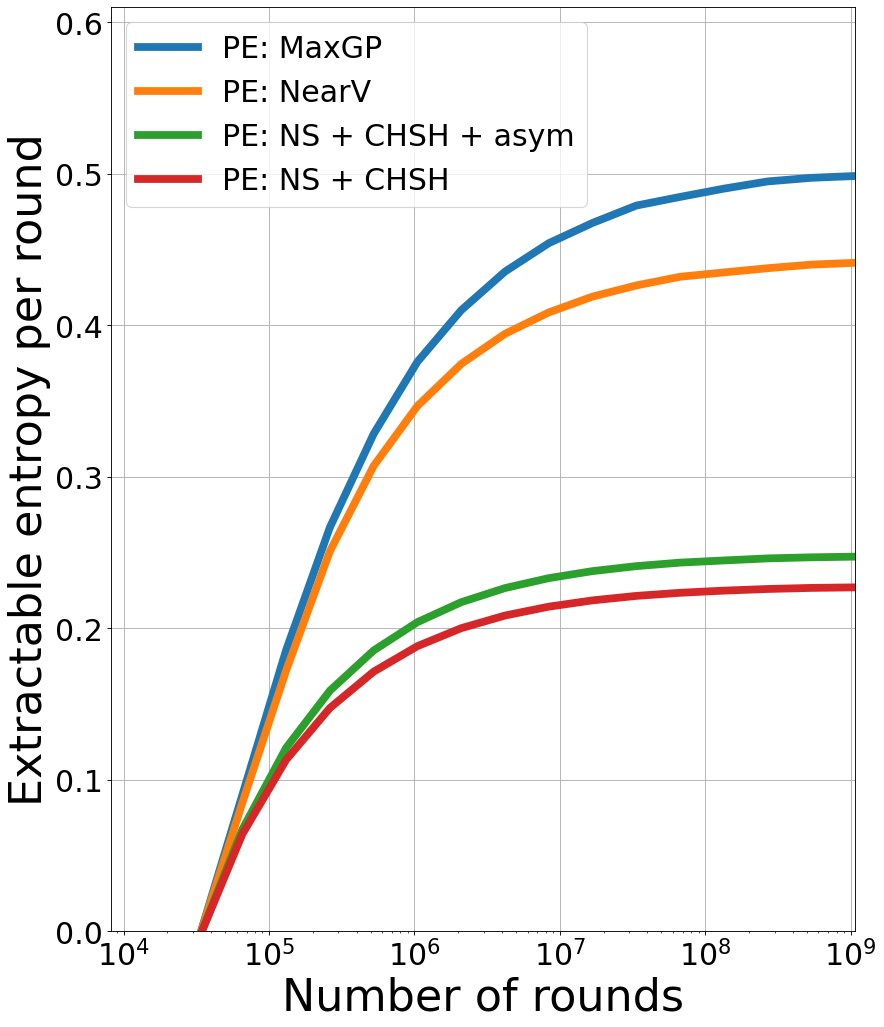

In [62]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, asymCHSH_wnd01_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, asymCHSH_wnd01_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, asymCHSH_wnd01_EntR_vs_N_NS_CHSH_asym, linewidth=7)
plt.plot(N_list, asymCHSH_wnd01_EntR_vs_N_NS_CHSH, linewidth=7)
plt.xscale('log')
plt.xlim([2**13, 2**30])
plt.ylim([0,0.61])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH + asym', 'PE: NS + CHSH'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()

### 7% white noise

In [64]:
# Generate quantum correlation
P_in = np.array([[1/4,1/4],[1/4,1/4]])
P_asymCHSH_wnd07 = getDistAsymCHSH(alpha, 0.07)
E_asymCHSH_wnd07 = p2E_bi(P_asymCHSH_wnd07)
print("CHSH value:", -np.einsum('ij,ij->', CHSH_ineq, E_asymCHSH_wnd07)+2)
print("Asymmetric CHSH value:", np.einsum('ijkl,ijkl->',asymCHSH_ineq,P_asymCHSH_wnd07))
sec = 2**(-128)

CHSH value: 2.07634145702335
Asymmetric CHSH value: 14.995799411835302


In [65]:
### Define the PE_analysis class for asymmetric CHSH correlation with 7% white noise ###
asymCHSH_wnd07 = PE_analysis(P_asymCHSH_wnd07, P_in)

In [66]:
### Generate various polytopes ###
# NS polytope
asymCHSH_wnd07.generate_Poly('NS')
# NS+CHSH polytope
asymCHSH_wnd07.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=10
asymCHSH_wnd07.generate_Poly('NearV', niter=10, cutoff=10) 
# 10 iterations of MaxGP algorithm
asymCHSH_wnd07.generate_Poly('MaxGP', niter=10, fix_input=(0,0))

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 6
---------------------
Iteration 1 starts
Chosen index: 9
---------------------
Iteration 2 starts
Chosen index: 3
---------------------
Iteration 3 starts
Chosen index: 5
---------------------
Iteration 4 starts
Chosen index: 9
---------------------
Iteration 5 starts
Chosen index: 4
---------------------
Iteration 6 starts
Chosen index: 7
---------------------
Iteration 7 starts
Chosen index: 7
---------------------
Iteration 8 starts
MOSEK failed -  too close to the quantum set.
Chosen index: 2
---------------------
Iteration 9 starts
MOSEK failed -  too close to the quantum set.
Chosen index: 4
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue t

In [67]:
### Extra polytope 'NS+CHSH+asymCHSH'
# Generate the polytope
asymCHSH_ineq_E = np.zeros((3,3))
asymCHSH_ineq_E[0,0] = 2*np.sqrt(1+alpha**2)
asymCHSH_ineq_E[1,1] = -alpha
asymCHSH_ineq_E[1,2] = -alpha
asymCHSH_ineq_E[2,1] = -1
asymCHSH_ineq_E[2,2] = 1

ineqs = positivity_NS[:] + [asymCHSH_wnd07.q_rel_CHSH_ineq[:]] + [asymCHSH_ineq_E]

H_rep = []
for ineq in ineqs:
    H_rep.append([str(i) for i in ineq.flatten()])
    
mat = cdd.Matrix(H_rep, number_type='fraction')
mat.rep_type = cdd.RepType.INEQUALITY
poly = cdd.Polyhedron(mat)
V_rep_fraction = np.array(poly.get_generators())

asymCHSH_V_rep = []
for ext in V_rep_fraction:
    asymCHSH_V_rep.append(np.array([float(i) for i in ext]))
    
# Add the polytope
asymCHSH_wnd07.add_Poly_option('NS+CHSH+asym', [asymCHSH_V_rep])

In [68]:
### Opimise PEF for fixed PEF power ###
asymCHSH_wnd07.max_power = 0.05
first_power = 0.0001
n_points = 151
# NS polytope
asymCHSH_wnd07.get_optF('NS', first_power=first_power, n_points=n_points)
# NS+CHSH polytope
asymCHSH_wnd07.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)
# NS+CHSH+asym polytope
asymCHSH_wnd07.get_optF('NS+CHSH+asym', first_power=first_power, n_points=n_points)
# NearV algorithm
asymCHSH_wnd07.get_optF('NearV', n_list=[9], first_power=first_power, n_points=n_points)
# MaxGP alforithm
asymCHSH_wnd07.get_optF('MaxGP', n_list=[9], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|███████████████████████████████████████| 151/151 [00:13<00:00, 11.31it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|███████████████████████████████████████| 151/151 [00:15<00:00,  9.50it/s]


=================== Optimise PEF for 'NS+CHSH+asym' ===================


100%|███████████████████████████████████████| 151/151 [00:21<00:00,  7.16it/s]


=================== Optimise PEF for 'NearV' ===================


100%|███████████████████████████████████████| 151/151 [05:06<00:00,  2.03s/it]


=================== Optimise PEF for 'MaxGP' ===================


100%|███████████████████████████████████████| 151/151 [03:40<00:00,  1.46s/it]


In [75]:
with open('asymCHSH_wnd07_alpha8.pkl', 'wb') as outp:
    pickle.dump(asymCHSH_wnd07, outp, pickle.HIGHEST_PROTOCOL)

# with open('asymCHSH_wnd07_alpha8.pkl', 'rb') as inp:
#     asymCHSH_wnd07 = pickle.load(inp)

In [69]:
### Analyse with different N
N_list = [2**n for n in range(13,31)]

asymCHSH_wnd07_EntR_vs_N_NS = []
asymCHSH_wnd07_EntR_vs_N_NS_CHSH = []
asymCHSH_wnd07_EntR_vs_N_NS_CHSH_asym = []
asymCHSH_wnd07_EntR_vs_N_NearV = []
asymCHSH_wnd07_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_asymCHSH_wnd07[a,b,x,y]*P_in[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = asymCHSH_wnd07.randomness_accumulation(N_raw, sec, 'NS', n_list=[0])
    asymCHSH_wnd07_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = asymCHSH_wnd07.randomness_accumulation(N_raw, sec, 'NS+CHSH', n_list=[0])
    asymCHSH_wnd07_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NS+CHSH+asym'
    NS_CHSH_asym = asymCHSH_wnd07.randomness_accumulation(N_raw, sec, 'NS+CHSH+asym', n_list=[0])
    asymCHSH_wnd07_EntR_vs_N_NS_CHSH_asym.append(NS_CHSH_asym[0]['entropy rate'])
    
    # 'NearV'
    NearV = asymCHSH_wnd07.randomness_accumulation(N_raw, sec, 'NearV', n_list=[9])
    asymCHSH_wnd07_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = asymCHSH_wnd07.randomness_accumulation(N_raw, sec, 'MaxGP', n_list=[9])
    asymCHSH_wnd07_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

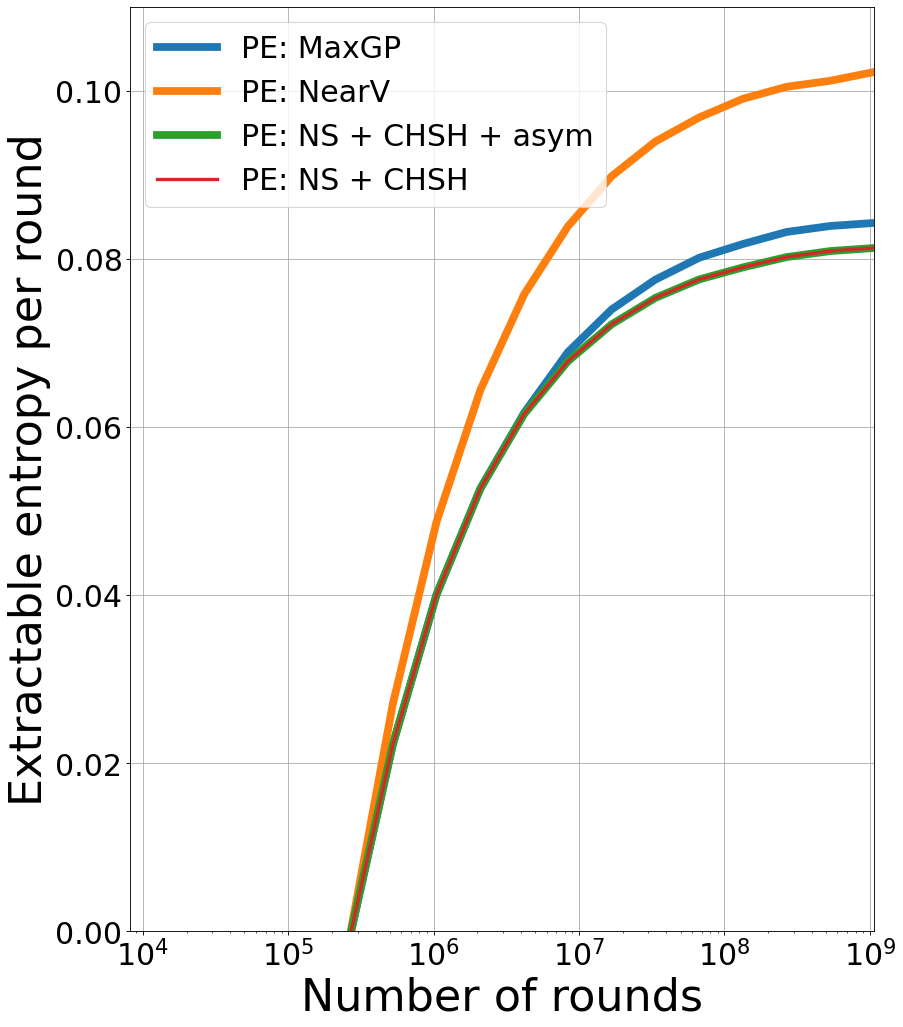

In [74]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, asymCHSH_wnd07_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, asymCHSH_wnd07_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, asymCHSH_wnd07_EntR_vs_N_NS_CHSH_asym, linewidth=7)
plt.plot(N_list, asymCHSH_wnd07_EntR_vs_N_NS_CHSH, linewidth=3)
plt.xscale('log')
plt.xlim([2**13, 2**30])
plt.ylim([0,0.11])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH + asym', 'PE: NS + CHSH'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()